In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [12]:
# View all of the classes that automap found
print("Automapped Classes:")
for class_name, mapped_class in Base.classes.items():
    print(f"{class_name}: {mapped_class}")

Automapped Classes:
measurement: <class 'sqlalchemy.ext.automap.measurement'>
station: <class 'sqlalchemy.ext.automap.station'>


In [14]:
# Save references to each table
measurements = Base.classes.measurement 
stations = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurements.date)).scalar()

print(most_recent_date)

2017-08-23


<Figure size 1000x600 with 0 Axes>

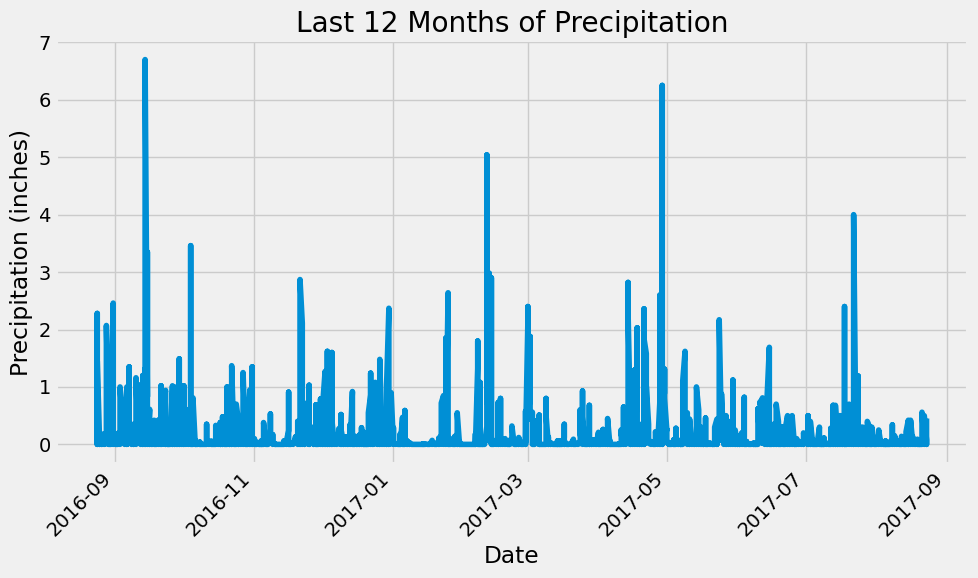

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

from datetime import datetime, timedelta


# Step 1: Find the most recent date in the dataset
most_recent_date = session.query(func.max(measurements.date)).scalar()

# Convert the most recent date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Step 2: Calculate the date one year ago
one_year_ago = most_recent_date - timedelta(days=365)

# Step 3: Query the last 12 months of precipitation data
precipitation_query = (
    session.query(measurements.date, measurements.prcp)
    .filter(measurements.date >= one_year_ago)
    .order_by(measurements.date)
    .all()
)

# Step 4: Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_query, columns=["date", "precipitation"])

# Handle missing precipitation values
precipitation_df["precipitation"] = precipitation_df["precipitation"].fillna(0)

# Convert 'date' column to datetime and sort by date
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])
precipitation_df = precipitation_df.sort_values(by="date")

# Step 5: Plot the data using Pandas and Matplotlib
plt.figure(figsize=(10, 6))
precipitation_df.plot(x="date", y="precipitation", kind="line", legend=False, figsize=(10, 6))
plt.title("Last 12 Months of Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()
plt.close()


In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df["precipitation"].describe()
summary_stats

count    2223.000000
mean        0.159951
std         0.441220
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(stations.station)).scalar()

# Display the result
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = (
    session.query(measurements.station, func.count(measurements.station))
    .group_by(measurements.station)
    .order_by(func.count(measurements.station).desc())
    .all()
)

print("Most Active Stations:")
for station, count in active_stations_query:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations_query[0][0]  


temperature_stats = (
    session.query(
        func.min(measurements.tobs),
        func.max(measurements.tobs),
        func.avg(measurements.tobs)
    )
    .filter(measurements.station == most_active_station)
    .first()
)


lowest_temp, highest_temp, avg_temp = temperature_stats


print(f"Temperature statistics for station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Temperature statistics for station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


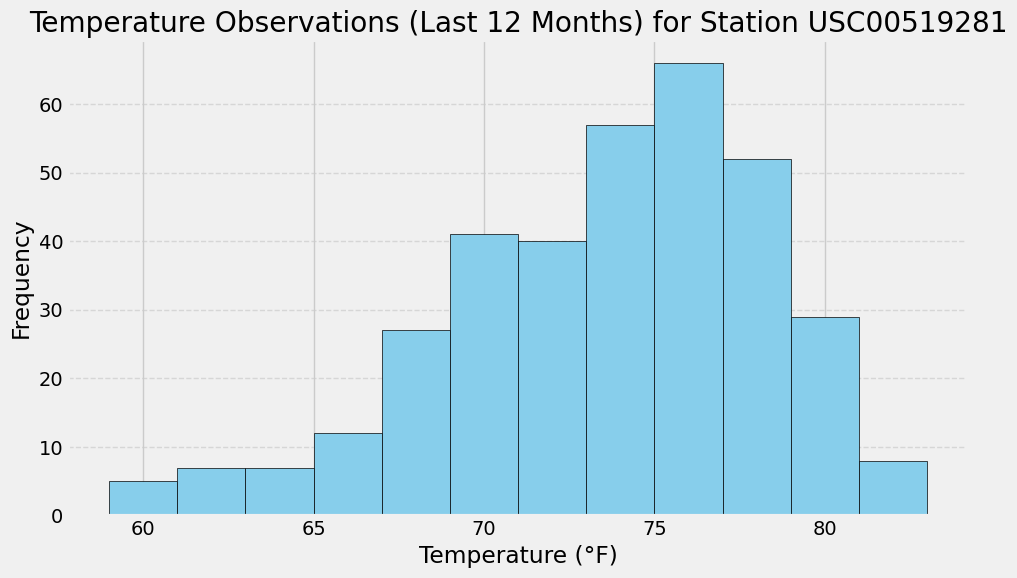

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for the most active station
tobs_query = (
    session.query(measurements.tobs)
    .filter(
        measurements.station == most_active_station,
        measurements.date >= one_year_ago
    )
    .all()
)

# Convert the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_query, columns=["tobs"])

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(tobs_df["tobs"], bins=12, edgecolor="black", color="skyblue")
plt.title(f"Temperature Observations (Last 12 Months) for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Close Session

In [36]:
# Close Session
session.close()